<a href="https://colab.research.google.com/github/nhtlongcs/VinBigData-Abnormalities-Detection/blob/ffyytt-effdet/EffDET_TRAIN_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!nvidia-smi

Thu Feb  4 23:51:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |  14061MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
!pip install kaggle
!cp '/content/gdrive/My Drive/Kaggle/kaggle.json' 'kaggle.json'
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
!kaggle datasets download -d trooperog/timm-efficientdet-weights
!unzip -qq -n timm-efficientdet-weights.zip
!rm timm-efficientdet-weights.zip

 99% 912M/919M [00:24<00:00, 46.8MB/s]
100% 919M/919M [00:25<00:00, 37.9MB/s]


In [27]:
!pip install -qq timm
!pip install -qq effdet
!pip install -qq pydicom 
!pip install -qq map-boxes
!pip install -qq ensemble_boxes
!pip install -qq git+https://github.com/bes-dev/mean_average_precision.git
!pip install -qq git+https://github.com/albumentations-team/albumentations.git

In [28]:
import sys
import torch
import os
from datetime import datetime
import time
import random
import cv2
import numpy as np
import pandas as pd
import multiprocessing
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from tqdm import *
import pydicom
import warnings
import imagesize
from ensemble_boxes import *
import zipfile
from mean_average_precision import MetricBuilder
from map_boxes import mean_average_precision_for_boxes
import multiprocessing

In [29]:
imgSize = 512
image_paths = 'data/vinbigdata/train'
SEED = 1312
class TrainGlobalConfig:
    num_workers = 8
    batch_size = 4
    n_epochs = 32
    lr = 0.005
    N_CLASSES = 15
    iou_thr = 0.4
    skip_box_thr = 0.1
    model = "tf_efficientdet_d7"
    weight = "timm_efficientdet_weights/tf_effdet_d7/tf_efficientdet_d7_53-6d1d7a95.pth"
    folder = "gdrive/MyDrive/2021_VINBIGDATA/D7/COLAB_FOLD0_FINAL_BACKGROUND"
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [31]:
if not os.path.exists('data/vinbigdata/'):
    os.makedirs('data/vinbigdata/')
    !cp "gdrive/MyDrive/2021_VINBIGDATA/train.csv" "data/vinbigdata/train.csv"

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
df = pd.read_csv('data/vinbigdata/train.csv')
#df = df[df['class_name'] != 'No finding']
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,fold
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,3
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,2
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,2
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,1


In [33]:
image_ids = df['image_id'].unique()
train_ids = df['image_id'][df['fold'] != 0].unique()
valid_ids = df['image_id'][df['fold'] == 0].unique()
print(len(train_ids), len(valid_ids))
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

12001 2999


In [34]:
if not os.path.exists('data/vinbigdata/train/'):
    !kaggle datasets download -d awsaf49/vinbigdata-original-image-dataset
    os.makedirs('data/vinbigdata/train/')
    with zipfile.ZipFile('vinbigdata-original-image-dataset.zip') as z:
        for filename in tqdm(image_ids):
            with open('data/vinbigdata/train/'+filename+'.jpg', 'wb+') as f:
                f.write(z.read('vinbigdata/train/'+filename+'.jpg'))

In [35]:
def get_train_transforms():
    return A.Compose(
        [
         A.ToGray(p=0.1),
         A.OneOf([
            A.MotionBlur(p=0.3),
            A.GaussianBlur(p=0.3),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.2),
         
        A.Rotate(limit=2, p = 0.3),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                 val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, 
                                       p=0.3),            
        ], p=0.5),

         A.HorizontalFlip(p=0.5),
         A.VerticalFlip(p=0.25),
         A.RandomRotate90(p=0.25),
         
         A.LongestMaxSize(max_size=imgSize),
         A.PadIfNeeded(min_height=imgSize, min_width=imgSize, p=1.0, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
         A.LongestMaxSize(max_size=imgSize),
         A.PadIfNeeded(min_height=imgSize, min_width=imgSize, p=1.0, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [36]:
def run_wbf(boxes, labels, w, h, wn, hn, iou_thr):
    scores = [np.array([0.9]*len(boxes))]
    
    boxes[:, 0] = (boxes[:, 0] / w)
    boxes[:, 1] = (boxes[:, 1] / h)
    boxes[:, 2] = (boxes[:, 2] / w)
    boxes[:, 3] = (boxes[:, 3] / h)
    boxes = [boxes]
    
    labels = [labels]
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr,
                                                  skip_box_thr=0.001)
    boxes[:, 0] = (boxes[:, 0] * wn)
    boxes[:, 1] = (boxes[:, 1] * hn)
    boxes[:, 2] = (boxes[:, 2] * wn)
    boxes[:, 3] = (boxes[:, 3] * hn)
    return boxes, labels

In [37]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_dir, transforms=None, test=False):
        super().__init__()

        self.image_ids = marking["image_id"].unique()
        self.image_dir = image_dir
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        w,h = image.shape[1], image.shape[0]
            
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = records['class_id'].values

        if (labels[0] == 14):
            boxes[:, 0] = 0
            boxes[:, 1] = 0
            boxes[:, 2] = w - 1
            boxes[:, 3] = h - 1

        boxes, labels = run_wbf(boxes, labels, w, h, w, h, TrainGlobalConfig.iou_thr)

        return image, boxes, labels

In [38]:
train_dataset = DatasetRetriever(
    marking=train_df,
    image_dir=image_paths,
    transforms=get_train_transforms(),
    test = False
)

validation_dataset = DatasetRetriever(
    marking=valid_df,
    image_dir=image_paths,
    transforms=get_valid_transforms(),
    test = True
)

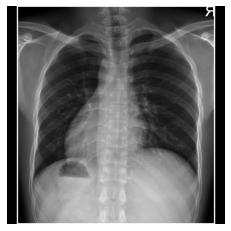

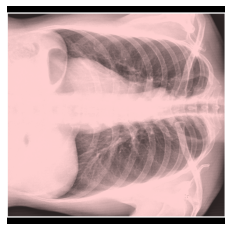

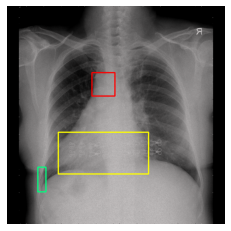

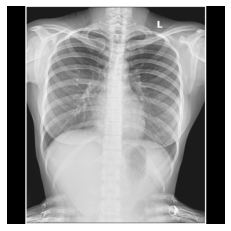

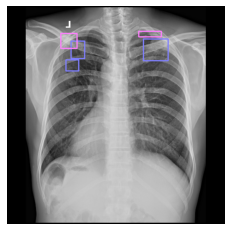

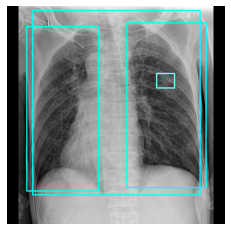

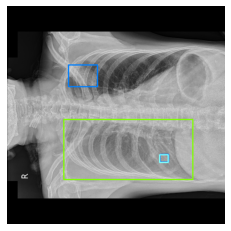

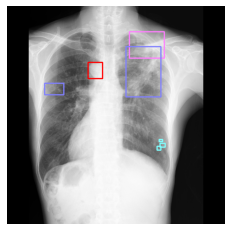

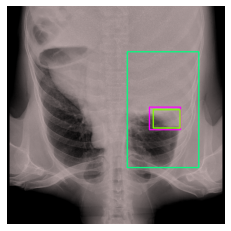

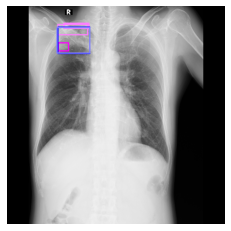

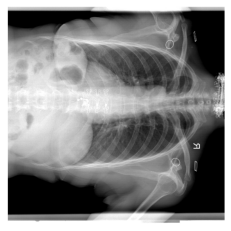

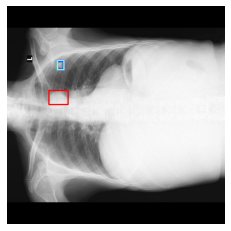

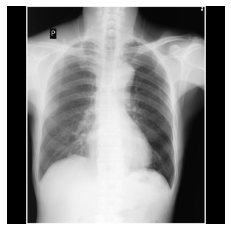

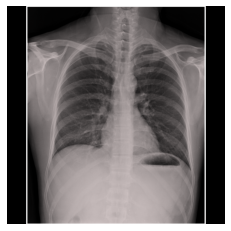

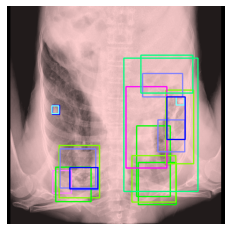

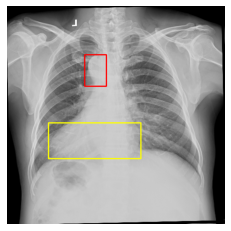

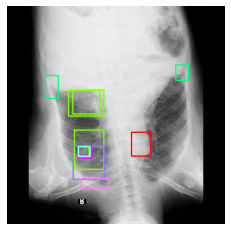

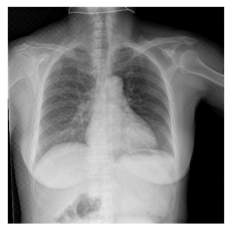

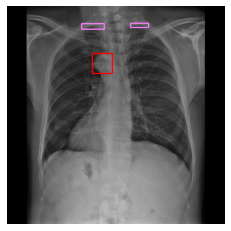

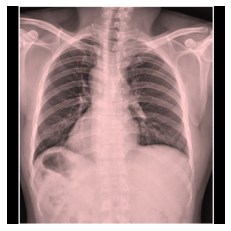

In [39]:
mapping = {0: (1,0,0), 1: (0,1,0), 2: (0,0,1), 3: (1,1,0), 
           4: (1,0,1), 5: (0,1,1),6: (0.5,1,0), 7: (0.5,1,0), 
           8: (0.5,1,1), 9: (0,0.5,1), 10: (0,1,0.5), 11: (1,0.5,1),
           12: (1,1,0.5), 13: (0.5,0.5,1), 14: (1,1,1)}

for i in range(20):
    image, target, image_id = train_dataset[i]
    boxes = target['boxes'].cpu().numpy().astype(np.int64)
    labels = target['labels'].cpu().numpy()

    numpy_image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    for box, label in zip(boxes, labels):
        cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), mapping[label], 2)

    ax.set_axis_off()
    ax.imshow(numpy_image)
    plt.show()

In [40]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [41]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.bug = {}

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
                

    def fit(self, train_loader, validation_loader, debug = False):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader, debug)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, mAP04 = self.validation(validation_loader, debug)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, mAP@0.4: {mAP04:.5f}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.model.eval()
            self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch-{round(summary_loss.avg*10000)}-{round(mAP04*10000)}.bin')
            
            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
            
            if (debug):
                break

    def validation(self, val_loader, debug):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        df = {'ImageID': [],
              'LabelName': [],
              'Conf':[],
              'XMin': [],
              'XMax': [],
              'YMin': [],
              'YMax': []}
        
        gt = {'ImageID': [],
                   'LabelName': [],
                   'XMin': [],
                   'XMax': [],
                   'YMin': [],
                   'YMax': []}
        mAP04 = 0
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        '\r'+f'Val Step {step}/{len(val_loader)}, ' + \
                        f'mAP@0.4: {mAP04:.5f}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end=''
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                

                self.bug['bbox'] = boxes
                self.bug['cls'] = labels
                self.bug['img_size'] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)
                self.bug['img_scale'] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)

                pred = self.model(images, self.bug)
                loss = pred['loss']
                det = pred['detections'].cpu().detach().numpy()

                for i in range(batch_size):
                    det_boxes = det[i, :, :4]/imgSize
                    det_labels = det[i, :, 5]
                    det_scores = det[i, :, 4]

                    det_boxes, det_scores, det_labels = weighted_boxes_fusion([det_boxes], [det_scores], [det_labels], 
                                                                              weights=None, iou_thr=self.config.iou_thr, skip_box_thr=self.config.skip_box_thr)
                    
                    indexes = np.where(det_labels == 14)[0]
                    det_boxes[indexes, 0] = 0.0
                    det_boxes[indexes, 1] = 0.0
                    det_boxes[indexes, 2] = 1.0
                    det_boxes[indexes, 3] = 1.0
                    
                    if (len(det_boxes) == 0):
                        df['ImageID'] += [image_ids[i]]
                        df['LabelName'] += [14.0]
                        df['Conf'] += [1.0]
                        df['XMin'] += [0.0]
                        df['YMin'] += [0.0]
                        df['XMax'] += [1.0]
                        df['YMax'] += [1.0]
                    else:
                        df['ImageID'] += [image_ids[i]]*len(det_boxes)
                        df['LabelName'] += det_labels.tolist()
                        df['Conf'] += det_scores.tolist()
                        df['XMin'] += det_boxes[:,0].tolist()
                        df['YMin'] += det_boxes[:,1].tolist()
                        df['XMax'] += det_boxes[:,2].tolist()
                        df['YMax'] += det_boxes[:,3].tolist()
                
                    boxes = targets[i]['boxes'].cpu().detach().numpy()/imgSize
                    labels = targets[i]['labels'].cpu().detach().numpy()
                    gt['ImageID'] += [image_ids[i]]*len(labels)
                    gt['LabelName'] += labels.tolist()
                    gt['XMin'] += boxes[:,0].tolist()
                    gt['YMin'] += boxes[:,1].tolist()
                    gt['XMax'] += boxes[:,2].tolist()
                    gt['YMax'] += boxes[:,3].tolist()
                
                summary_loss.update(loss.detach().item(), batch_size)
                mAP04,_ = mean_average_precision_for_boxes(pd.DataFrame().from_dict(gt).values,
                                                 pd.DataFrame().from_dict(df).values,
                                                 iou_threshold=self.config.iou_thr, verbose = False)

            if (debug):
                break
        
        pd.DataFrame().from_dict(gt).to_csv('gt.csv')
        pd.DataFrame().from_dict(df).to_csv('df.csv')
                
        return summary_loss, mAP04

    def train_one_epoch(self, train_loader, debug):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        '\r'+f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end=''
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            self.bug['bbox'] = boxes
            self.bug['cls'] = labels
            
            loss = self.model(images, self.bug)['loss']
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()
            
            if (debug):
                break
        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print('\r'+message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [42]:
def get_net():
    config = get_efficientdet_config(TrainGlobalConfig.model)
    config.image_size = [imgSize, imgSize]
    config.norm_kwargs=dict(eps=.001, momentum=.01)

    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load(TrainGlobalConfig.weight)

    net.load_state_dict(checkpoint)
    net.reset_head(num_classes=TrainGlobalConfig.N_CLASSES)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, config)

In [43]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(debug = False):
    net = get_net()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader, debug)

In [ ]:
run_training()